# Taiwanese Credit Card Default Modeling.

The goal of this project to find a model which best predicts whether or not a person will default on their credit card payment. 

#### Data Set Information:

- This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

- NT is the abbreviation for New Taiwan.

#### Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    - X6 = the repayment status in September, 2005; 
    - X7 = the repayment status in August, 2005; . . .;
    - etc...
    - X11 = the repayment status in April, 2005. 
    - The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). 
    - X12 = amount of bill statement in September, 2005;
    - etc...
    - X13 = amount of bill statement in August, 2005; . . .; 
    - X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). 
    - X18 = amount paid in September, 2005; 
    - X19 = amount paid in August, 2005; . . .;
    - etc...
    - X23 = amount paid in April, 2005. 
    

Median salary by education level:

1. Graduate school and above = 831496
2. University = 575575
3. Junior college = 526270
4. Senior high school = 417073
5. Junior high school = 394230
6. Primary school, Supplementary school and illiteracy = 292370

References:

https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end

https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166

https://win.dgbas.gov.tw/fies/e12.asp?year=94

# Libraries

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV, SelectKBest, f_regression, mutual_info_regression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import pprint

In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

## Helper Functions

In [100]:
def heatmap_corr(dataframe):
    # Plots a heatmap of correlation between features with masking.
    fig, ax = plt.subplots(figsize=(20,20))
    mask=np.zeros_like(dataframe.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    color_map = sns.color_palette("hot_r")
    ax = sns.heatmap(dataframe.corr(), cmap = color_map, mask=mask, square=True, annot=True)

def knn(X_train, y_train, X_test, y_test, **kwargs):
    knn = KNeighborsClassifier(**kwargs)
    # train
    knn.fit(X_train, y_train)
    # test
    y_pred_class = knn.predict(X_test)

    print('Classification Accuracy: ', format(accuracy_score(y_test, y_pred_class), '.3f'))
    print('Precision score: ', format(precision_score(y_test, y_pred_class), '.3f'))
    print('Recall score: ', format(recall_score(y_test, y_pred_class), '.3f'))
    print('F1 score: ', format(f1_score(y_test, y_pred_class), '.3f'))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def logiRegr(X_train, y_train, X_test, y_test,**kwargs):
    logreg = LogisticRegression(**kwargs)
    logreg.fit(X_train, y_train)
    # examine coefficients
    pprint.pprint(list(zip(X_train.columns,logreg.coef_[0])))
    # class predictions (not predicted probabilities)
    y_pred_class = logreg.predict(X_test)
    print('Classification Accuracy: ', format(accuracy_score(y_test, y_pred_class), '.3f'))
    print('Precision score: ', format(precision_score(y_test, y_pred_class), '.3f'))
    print('Recall score: ', format(recall_score(y_test, y_pred_class), '.3f'))
    print('F1 score: ', format(f1_score(y_test, y_pred_class), '.3f'))
    # plot confusion matrix
    cm = confusion_matrix(y_test,y_pred_class)
    classes = ['NON-default','DEFAULT']
    plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    
def deciTree(X_train, y_train, X_test, y_test,**kwargs):
    dt = DecisionTreeClassifier(random_state=1, **kwargs) # Create Decision Tree classifer object
    dt_fit = clf.fit(X_train,y_train) # Train Decision Tree Classifer
    y_pred_train = dt_fit.predict(X_train) #predict the training set
    y_pred_class = dt_fit.predict(X_test) #Predict the response for test dataset

    # Model Accuracy, how often is the classifier correct?
    print('Classification Accuracy: ', format(accuracy_score(y_test, y_pred_class), '.3f'))
    print('Precision score: ', format(precision_score(y_test, y_pred_class), '.3f'))
    print('Recall score: ', format(recall_score(y_test, y_pred_class), '.3f'))
    print('F1 score: ', format(f1_score(y_test, y_pred_class), '.3f'))

def randomForest(X_train, y_train, X_test, y_test,**kwargs):
    rf = RandomForestClassifier(random_state=1, **kwargs) # Create Decision Tree classifer object
    rf_fit = rf.fit(X_train,y_train) # Train Decision Tree Classifer
    y_pred_train = rf_fit.predict(X_train) #predict the training set
    y_pred_class = rf_fit.predict(X_test) #Predict the response for test dataset

    # Model Accuracy, how often is the classifier correct?
    print('Classification Accuracy: ', format(accuracy_score(y_test, y_pred_class), '.3f'))
    print('Precision score: ', format(precision_score(y_test, y_pred_class), '.3f'))
    print('Recall score: ', format(recall_score(y_test, y_pred_class), '.3f'))
    print('F1 score: ', format(f1_score(y_test, y_pred_class), '.3f'))

def gridHyper(estimator, params, cv, scoring, X_train, y_train, X_test, y_test):
    gridSearch = GridSearchCV(estimator, params, cv=cv, scoring=scoring) #create the instance of GridSearchCV
    gridSearch.fit(X_train,y_train) #fit the Gridsearch to our data
    # examine the best model
    print('Training Best Score: ', gridSearch.best_score_, '\n')
    print('Training Best Params: v \n', gridSearch.best_params_, '\n\n')
    print('Training Best Estimator: v \n', gridSearch.best_estimator_, '\n\n')
    
    
    # Use the best estimator to predict the response for test dataset
    y_pred = gridSearch.best_estimator_.predict(X_test)
    # Model Accuracy, how often is the classifier correct?
    print("Testing Accuracy:", metrics.f1_score(y_test, y_pred))
    return y_pred

## 1. Data Prep

In [32]:
df = pd.read_csv('classification_lab_data.csv')

In [33]:
df.head(30)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,50000,1,2,2,49,0,0,0,0,0,0,90231,90647,92309,93880,99418,101392,2852,2784,2603,10000,3164,2868,1
1,30000,1,2,1,39,0,0,0,0,0,0,20893,22206,19273,16469,14670,11214,2007,2000,2000,417,1500,1500,0
2,260000,1,1,2,27,0,0,0,0,0,0,158711,129796,101721,76699,56738,39134,30000,4132,3410,2600,1800,1200,0
3,200000,2,2,1,33,0,0,0,0,0,0,23762,25944,26988,25237,22131,13774,4000,2000,600,3000,4000,100,0
4,50000,1,1,2,27,0,0,0,0,0,0,14614,15622,16342,17653,17697,18068,1558,1278,1589,633,656,783,0
5,150000,2,1,1,46,0,0,0,0,0,0,21787,22817,24134,24635,29032,29766,1382,1699,1200,5000,1214,1500,0
6,400000,2,2,2,41,-2,-2,-2,-2,-2,-2,43672,678,330,330,330,330,678,330,330,330,330,330,1
7,360000,2,2,2,31,0,-1,-1,-1,-2,-2,3386,5964,1340,1650,4350,4792,5964,1340,1650,4350,4792,40682,0
8,160000,2,2,2,32,2,2,2,2,-1,0,400,400,400,0,20818,20818,0,0,0,20818,0,0,0
9,500000,2,1,1,44,0,-1,-1,0,0,0,329570,71921,367979,294969,189612,128459,72001,368199,6486,234,90,167116,0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Data columns (total 24 columns):
LIMIT_BAL                     23999 non-null int64
SEX                           23999 non-null int64
EDUCATION                     23999 non-null int64
MARRIAGE                      23999 non-null int64
AGE                           23999 non-null int64
PAY_0                         23999 non-null int64
PAY_2                         23999 non-null int64
PAY_3                         23999 non-null int64
PAY_4                         23999 non-null int64
PAY_5                         23999 non-null int64
PAY_6                         23999 non-null int64
BILL_AMT1                     23999 non-null int64
BILL_AMT2                     23999 non-null int64
BILL_AMT3                     23999 non-null int64
BILL_AMT4                     23999 non-null int64
BILL_AMT5                     23999 non-null int64
BILL_AMT6                     23999 non-null int64
PAY_AMT1                

In [35]:
df.isna().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [36]:
df[df.duplicated(keep="first")].count()

LIMIT_BAL                     21
SEX                           21
EDUCATION                     21
MARRIAGE                      21
AGE                           21
PAY_0                         21
PAY_2                         21
PAY_3                         21
PAY_4                         21
PAY_5                         21
PAY_6                         21
BILL_AMT1                     21
BILL_AMT2                     21
BILL_AMT3                     21
BILL_AMT4                     21
BILL_AMT5                     21
BILL_AMT6                     21
PAY_AMT1                      21
PAY_AMT2                      21
PAY_AMT3                      21
PAY_AMT4                      21
PAY_AMT5                      21
PAY_AMT6                      21
default payment next month    21
dtype: int64

In [37]:
dups = list(df[df.duplicated(keep="first")].index.values)
df.drop(df.index[dups],inplace=True)

In [38]:
df.reset_index(drop=True, inplace=True)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23978 entries, 0 to 23977
Data columns (total 24 columns):
LIMIT_BAL                     23978 non-null int64
SEX                           23978 non-null int64
EDUCATION                     23978 non-null int64
MARRIAGE                      23978 non-null int64
AGE                           23978 non-null int64
PAY_0                         23978 non-null int64
PAY_2                         23978 non-null int64
PAY_3                         23978 non-null int64
PAY_4                         23978 non-null int64
PAY_5                         23978 non-null int64
PAY_6                         23978 non-null int64
BILL_AMT1                     23978 non-null int64
BILL_AMT2                     23978 non-null int64
BILL_AMT3                     23978 non-null int64
BILL_AMT4                     23978 non-null int64
BILL_AMT5                     23978 non-null int64
BILL_AMT6                     23978 non-null int64
PAY_AMT1                

## 2. EDA

In [40]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [41]:
df.rename({'PAY_6': 'payment_status_apr', 'PAY_5': 'payment_status_may', 'PAY_4': 'payment_status_jun', 
           'PAY_3': 'payment_status_jul', 'PAY_2': 'payment_status_aug', 'PAY_0': 'payment_status_sep',
           'BILL_AMT6': 'bill_apr', 'BILL_AMT5': 'bill_may', 'BILL_AMT4': 'bill_jun',
           'BILL_AMT3': 'bill_jul', 'BILL_AMT2': 'bill_aug', 'BILL_AMT1': 'bill_sep',
           'PAY_AMT6': 'payments_apr', 'PAY_AMT5': 'payments_may', 'PAY_AMT4': 'payments_jun',
           'PAY_AMT3': 'payments_jul', 'PAY_AMT2': 'payments_aug', 'PAY_AMT1': 'payments_sep',
           'default payment next month': 'defaulted'}, axis=1, inplace=True)

In [42]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'payment_status_sep', 'payment_status_aug', 'payment_status_jul',
       'payment_status_jun', 'payment_status_may', 'payment_status_apr',
       'bill_sep', 'bill_aug', 'bill_jul', 'bill_jun', 'bill_may', 'bill_apr',
       'payments_sep', 'payments_aug', 'payments_jul', 'payments_jun',
       'payments_may', 'payments_apr', 'defaulted'],
      dtype='object')

In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,23978.0,167785.873718,129917.562562,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,23978.0,1.603595,0.489161,1.0,1.00,2.0,2.00,2.0
EDUCATION,23978.0,1.857161,0.791944,0.0,1.00,2.0,2.00,6.0
MARRIAGE,23978.0,1.550755,0.522455,0.0,1.00,2.0,2.00,3.0
AGE,23978.0,35.525440,9.255010,21.0,28.00,34.0,42.00,79.0
payment_status_sep,23978.0,-0.015014,1.120667,-2.0,-1.00,0.0,0.00,8.0
payment_status_aug,23978.0,-0.133497,1.192413,-2.0,-1.00,0.0,0.00,8.0
payment_status_jul,23978.0,-0.164401,1.192697,-2.0,-1.00,0.0,0.00,8.0
payment_status_jun,23978.0,-0.215906,1.167915,-2.0,-1.00,0.0,0.00,8.0
payment_status_may,23978.0,-0.260197,1.132201,-2.0,-1.00,0.0,0.00,8.0


In [44]:
df['EDUCATION'].value_counts()

2    11183
1     8428
3     3992
5      223
4      100
6       41
0       11
Name: EDUCATION, dtype: int64

In [45]:
df.loc[df['EDUCATION'].isin([0,4,5,6]), 'defaulted'].value_counts()

0    351
1     24
Name: defaulted, dtype: int64

In [46]:
df.loc[df['EDUCATION']==0]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_sep,bill_aug,bill_jul,bill_jun,bill_may,bill_apr,payments_sep,payments_aug,payments_jul,payments_jun,payments_may,payments_apr,defaulted
1295,50000,2,0,1,40,0,0,0,0,0,0,44749,46229,46798,47647,40500,41921,2229,2298,2100,2500,1921,8432,0
2033,270000,1,0,2,39,1,-1,-1,-1,-1,-2,0,10193,69553,18607,0,0,10193,70213,19008,399,0,0,0
3940,160000,1,0,1,47,-1,-1,-1,-1,0,-1,386,907,3707,6987,3853,4613,907,3707,6991,77,4613,4099,0
6042,230000,2,0,2,47,-1,-1,-1,2,-1,-1,8394,5743,1336,255,5425,4838,5743,1598,0,5425,4838,3840,0
7924,350000,2,0,2,53,-1,-1,-1,-1,-1,-1,5095,4815,61044,22611,1385,6043,4840,61349,22687,1389,6058,1153,0
8797,210000,1,0,2,45,-2,-2,-2,-2,-2,-2,2563,5854,1032,788,3499,3372,5854,1032,788,3565,3372,15381,0
10417,250000,1,0,1,35,-2,-2,-2,-2,-2,-2,22839,7745,12035,33604,0,1190,7783,12046,33718,0,1190,590,0
10559,290000,2,0,2,38,1,-1,-1,-1,-1,-1,0,1437,3070,1406,2196,1481,1437,3078,1406,2196,1481,0,0
11983,360000,1,0,2,30,0,0,-1,0,0,-1,40250,23022,12272,34345,36777,30,23000,12280,25007,25008,1767,3300,0
15310,220000,2,0,1,35,-2,-2,-2,-2,-2,-2,0,319,10567,319,319,319,319,10567,319,319,319,2420,0


In [47]:
df = df[df.EDUCATION != 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23967 entries, 0 to 23977
Data columns (total 24 columns):
LIMIT_BAL             23967 non-null int64
SEX                   23967 non-null int64
EDUCATION             23967 non-null int64
MARRIAGE              23967 non-null int64
AGE                   23967 non-null int64
payment_status_sep    23967 non-null int64
payment_status_aug    23967 non-null int64
payment_status_jul    23967 non-null int64
payment_status_jun    23967 non-null int64
payment_status_may    23967 non-null int64
payment_status_apr    23967 non-null int64
bill_sep              23967 non-null int64
bill_aug              23967 non-null int64
bill_jul              23967 non-null int64
bill_jun              23967 non-null int64
bill_may              23967 non-null int64
bill_apr              23967 non-null int64
payments_sep          23967 non-null int64
payments_aug          23967 non-null int64
payments_jul          23967 non-null int64
payments_jun          23967 non

In [48]:
df.loc[df['defaulted']==1].head(200)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_sep,bill_aug,bill_jul,bill_jun,bill_may,bill_apr,payments_sep,payments_aug,payments_jul,payments_jun,payments_may,payments_apr,defaulted
0,50000,1,2,2,49,0,0,0,0,0,0,90231,90647,92309,93880,99418,101392,2852,2784,2603,10000,3164,2868,1
6,400000,2,2,2,41,-2,-2,-2,-2,-2,-2,43672,678,330,330,330,330,678,330,330,330,330,330,1
13,200000,1,1,1,37,-1,-1,0,0,0,0,2896,10706,10323,8440,4963,10222,10720,3014,1027,2022,10017,2030,1
17,200000,1,1,2,32,-1,-1,-1,-2,-2,-2,1125,2182,0,0,0,0,2182,0,0,0,0,0,1
20,120000,2,2,3,37,2,2,2,2,2,2,26446,27719,27570,28318,29217,28598,2000,600,1500,1500,0,1056,1
22,500000,2,2,2,23,4,3,2,0,0,0,507726,509229,499936,505507,484612,419643,10000,0,14000,16500,16000,19000,1
23,10000,2,2,2,36,1,2,0,0,0,0,7081,6819,7996,9004,9180,9371,0,1290,1298,474,487,500,1
34,200000,1,1,2,29,-1,-1,-1,0,-1,-1,4810,0,726,726,495,1402,0,726,0,495,1562,1420,1
40,10000,2,2,1,24,0,0,0,0,0,0,6902,7922,8939,9533,9692,9829,1142,1159,1140,692,829,1000,1
46,220000,2,2,1,41,-1,2,2,-1,2,-1,650,650,325,950,475,325,325,0,950,0,325,325,1


### 2a. Kitchen Sink Model

In [49]:
X_base = df.drop('defaulted', axis = 1)
y_base = df['defaulted']
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, random_state=1)

In [50]:
scaler = StandardScaler()  
scaler.fit(X_base_train)

X_base_train_scaled = pd.DataFrame(scaler.transform(X_base_train), columns=X_base_train.columns) 
X_base_test_scaled = pd.DataFrame(scaler.transform(X_base_test), columns=X_base_test.columns)

/Users/jmcneilkeller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[('LIMIT_BAL', -0.12535703487050326),
 ('SEX', -0.05338145491714185),
 ('EDUCATION', -0.06839512575313254),
 ('MARRIAGE', -0.08661200097645053),
 ('AGE', 0.07189547422963871),
 ('payment_status_sep', 0.6549284507170701),
 ('payment_status_aug', 0.0841529805009638),
 ('payment_status_jul', 0.09036131780650479),
 ('payment_status_jun', 0.057898678816880746),
 ('payment_status_may', 0.013372208375293534),
 ('payment_status_apr', 0.033077590283955925),
 ('bill_sep', -0.31800630697919063),
 ('bill_aug', 0.19733727500756035),
 ('bill_jul', 0.000331859011339387),
 ('bill_jun', 0.05823713094425006),
 ('bill_may', 0.08237818803781616),
 ('bill_apr', -0.10812937189086541),
 ('payments_sep', -0.2293174103840951),
 ('payments_aug', -0.10796362502007548),
 ('payments_jul', -0.042168207185497006),
 ('payments_jun', -0.064314019974771),
 ('payments_may', -0.006225668537229919),
 ('payments_apr', -0.03932189434981095)]
Classification Accuracy:  0.807
Precision score:  0.685
Recall score:  0.240
F1 sco

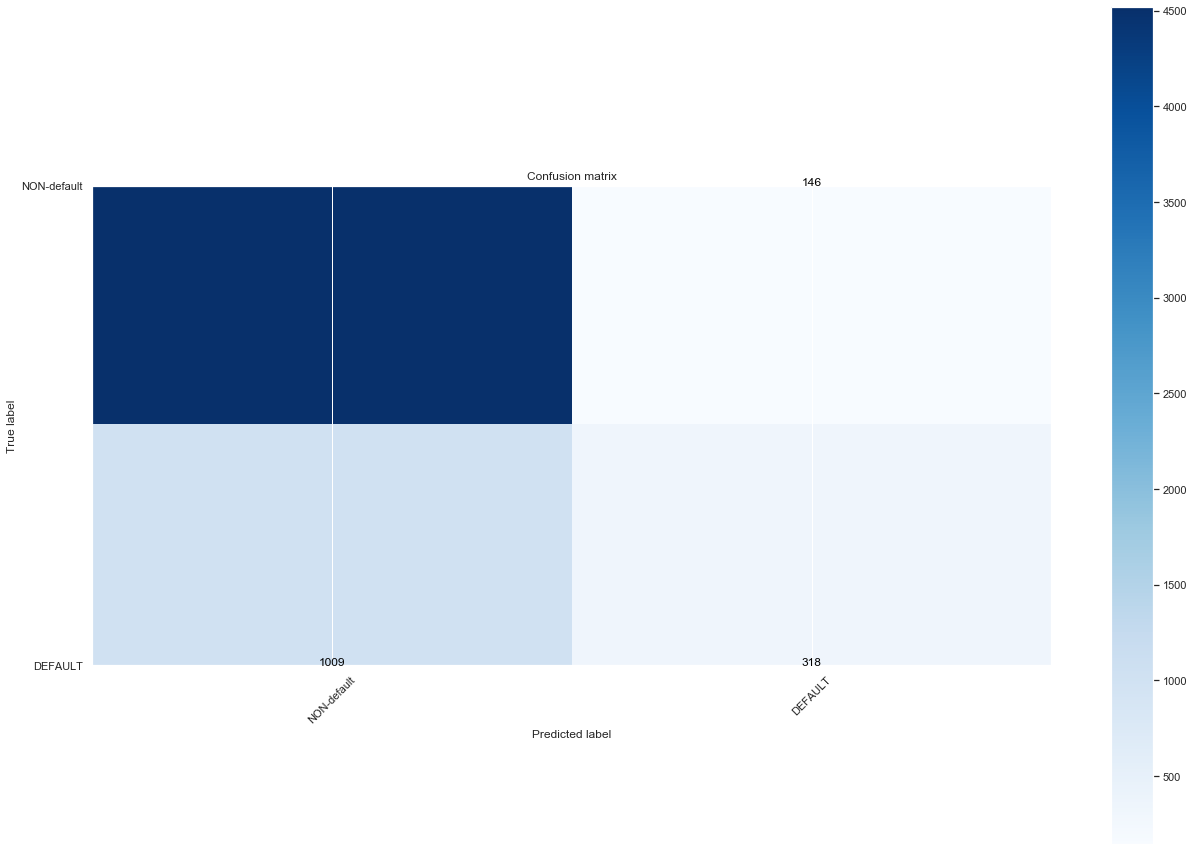

In [51]:
logiRegr(X_base_train_scaled,y_base_train,X_base_test_scaled,y_base_test)

### 2b. More EDA. 

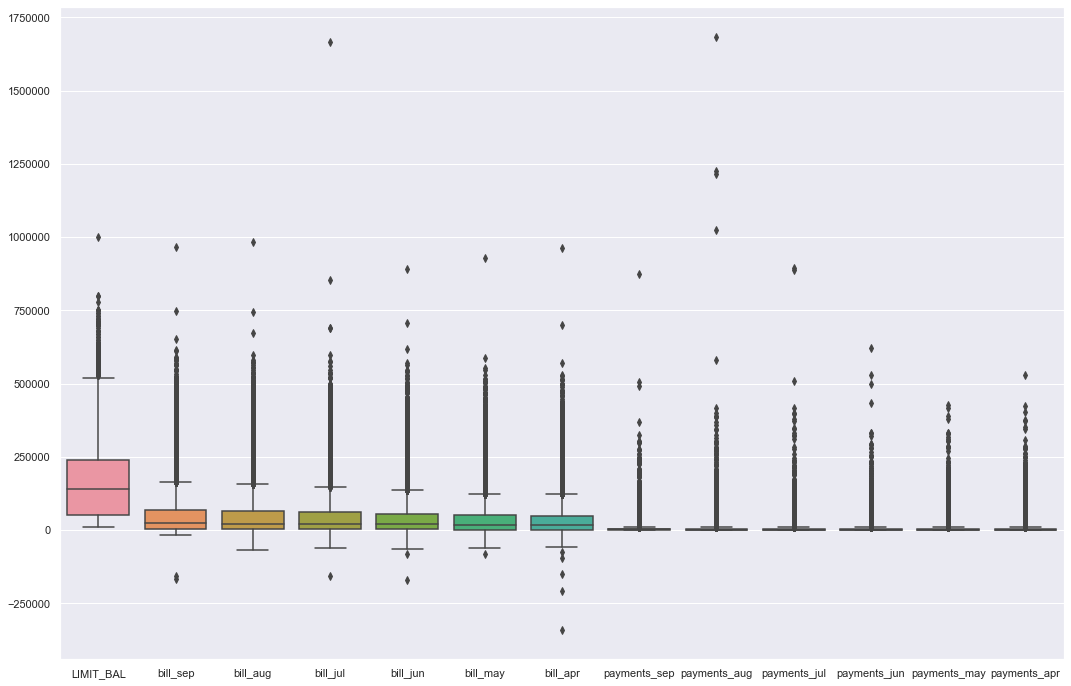

In [52]:
cols = df.drop(['SEX', 'EDUCATION', 'MARRIAGE','AGE','payment_status_sep','payment_status_aug','payment_status_jul',
                'payment_status_jun','payment_status_may','payment_status_apr','defaulted'], axis=1)
sns.set(rc={'figure.figsize':(18,12)})
sns.boxplot(data=cols)

In [53]:
df = df[(np.abs(stats.zscore(df)) < 4).all(axis=1)]

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22316 entries, 0 to 23977
Data columns (total 24 columns):
LIMIT_BAL             22316 non-null int64
SEX                   22316 non-null int64
EDUCATION             22316 non-null int64
MARRIAGE              22316 non-null int64
AGE                   22316 non-null int64
payment_status_sep    22316 non-null int64
payment_status_aug    22316 non-null int64
payment_status_jul    22316 non-null int64
payment_status_jun    22316 non-null int64
payment_status_may    22316 non-null int64
payment_status_apr    22316 non-null int64
bill_sep              22316 non-null int64
bill_aug              22316 non-null int64
bill_jul              22316 non-null int64
bill_jun              22316 non-null int64
bill_may              22316 non-null int64
bill_apr              22316 non-null int64
payments_sep          22316 non-null int64
payments_aug          22316 non-null int64
payments_jul          22316 non-null int64
payments_jun          22316 non

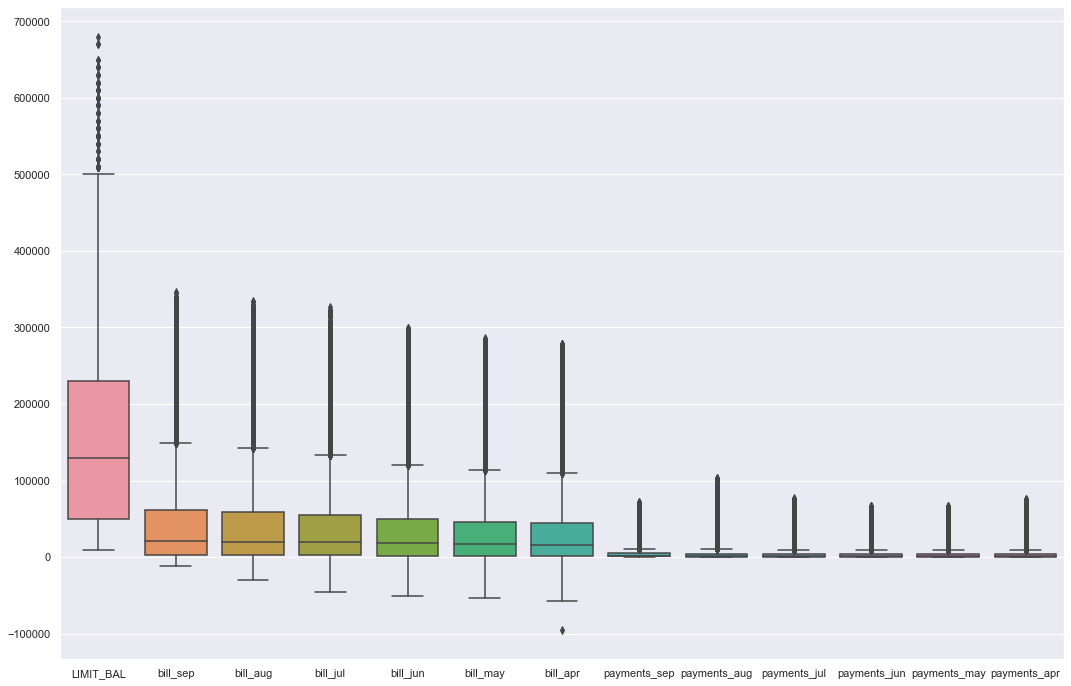

In [55]:
cols = df.drop(['SEX', 'EDUCATION', 'MARRIAGE','AGE','payment_status_sep','payment_status_aug','payment_status_jul',
                'payment_status_jun','payment_status_may','payment_status_apr','defaulted'], axis=1)
sns.set(rc={'figure.figsize':(18,12)})
sns.boxplot(data=cols)

In [56]:
df.nsmallest(10,'bill_apr')

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_sep,bill_aug,bill_jul,bill_jun,bill_may,bill_apr,payments_sep,payments_aug,payments_jul,payments_jun,payments_may,payments_apr,defaulted
18677,320000,1,1,2,31,1,-2,-2,-2,-2,-2,-6029,-9119,-46127,-50616,-53007,-94625,185,28,12,208,8,14,1
5235,290000,1,1,2,38,-2,-2,-2,-2,-2,-2,2318,1818,2057,2278,1224,-57060,1827,2066,2287,1242,1827,60860,0
5796,450000,2,2,1,37,-1,-1,-1,-1,-1,-1,1212,791,2663,783,1730,-51443,1032,2663,783,1730,0,70803,1
3807,260000,2,2,2,26,0,0,0,0,-1,-1,164351,164244,158124,62373,746,-45734,7000,5115,2000,746,5025,54836,0
23311,120000,1,2,3,48,0,0,0,0,0,-2,61673,60679,61943,58744,-36156,-36156,2345,3419,5026,15651,0,0,0
20622,80000,1,3,1,42,-2,-2,-2,-2,-2,-2,-1590,-6256,-10922,-15588,-20254,-24920,4666,4666,4666,4666,266,0,0
5408,450000,1,2,1,66,-2,-2,-2,-2,-2,-2,-81,15029,-1318,-9157,-20753,-22680,15110,40,258,9,23,27,0
2338,50000,2,2,1,34,-2,-1,0,0,0,0,50680,50655,50710,50503,40140,-21364,50702,2033,1776,2000,29000,59901,0
8747,150000,2,2,1,45,-1,-1,-1,-2,-2,-2,16611,18540,18204,16132,-5880,-20544,18552,18267,16142,5880,13707,1088,0
21135,260000,2,1,1,61,1,-2,-2,-2,-2,-2,-551,16449,-20320,-20320,-20320,-20320,17000,2631,0,0,0,0,0


In [57]:
df.corr()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_sep,bill_aug,bill_jul,bill_jun,bill_may,bill_apr,payments_sep,payments_aug,payments_jul,payments_jun,payments_may,payments_apr,defaulted
LIMIT_BAL,1.000000,0.035374,-0.232611,-0.110502,0.129283,-0.285626,-0.313337,-0.307433,-0.291037,-0.274833,-0.260068,0.180446,0.167532,0.170444,0.175362,0.175479,0.165700,0.215828,0.212742,0.224378,0.218519,0.214600,0.220331,-0.152731
SEX,0.035374,1.000000,0.011408,-0.033689,-0.092083,-0.053878,-0.069139,-0.064433,-0.057862,-0.051764,-0.043056,-0.022761,-0.021343,-0.017785,-0.011054,-0.006097,-0.003911,0.002998,0.003744,0.016377,0.016648,0.019998,0.025983,-0.041052
EDUCATION,-0.232611,0.011408,1.000000,-0.145981,0.183089,0.106258,0.124171,0.115755,0.109004,0.098724,0.082575,0.029435,0.028797,0.022140,0.011587,0.002430,0.002685,-0.053994,-0.054200,-0.056957,-0.060914,-0.057771,-0.058723,0.027724
MARRIAGE,-0.110502,-0.033689,-0.145981,1.000000,-0.409418,0.021149,0.027741,0.038854,0.041405,0.044296,0.041912,-0.012825,-0.009608,-0.008933,-0.009939,-0.010431,-0.010943,-0.006717,-0.001587,-0.006797,-0.009870,-0.011141,0.000527,-0.019965
AGE,0.129283,-0.092083,0.183089,-0.409418,1.000000,-0.041652,-0.049015,-0.052548,-0.053129,-0.058900,-0.054506,0.030649,0.027920,0.026787,0.023652,0.021452,0.020644,0.019115,0.016843,0.020066,0.024530,0.023865,0.011446,0.012398
payment_status_sep,-0.285626,-0.053878,0.106258,0.021149,-0.041652,1.000000,0.646881,0.551965,0.522071,0.497766,0.469328,0.208830,0.218961,0.217767,0.220496,0.221330,0.220818,-0.103099,-0.102324,-0.095615,-0.079960,-0.079995,-0.079145,0.322279
payment_status_aug,-0.313337,-0.069139,0.124171,0.027741,-0.049015,0.646881,1.000000,0.760853,0.656339,0.621653,0.581620,0.270716,0.277153,0.275774,0.276359,0.274853,0.273250,-0.090915,-0.063563,-0.057705,-0.044436,-0.034560,-0.043129,0.255947
payment_status_jul,-0.307433,-0.064433,0.115755,0.038854,-0.052548,0.551965,0.760853,1.000000,0.765381,0.672454,0.620153,0.251181,0.284957,0.285043,0.287772,0.286602,0.284621,0.028697,-0.085238,-0.054718,-0.040377,-0.027527,-0.039112,0.228341
payment_status_jun,-0.291037,-0.057862,0.109004,0.041405,-0.053129,0.522071,0.656339,0.765381,1.000000,0.801409,0.692974,0.256006,0.285058,0.311887,0.315599,0.313841,0.313391,0.014769,0.029491,-0.075257,-0.033534,-0.010533,-0.022938,0.207913
payment_status_may,-0.274833,-0.051764,0.098724,0.044296,-0.058900,0.497766,0.621653,0.672454,0.801409,1.000000,0.799401,0.259488,0.285904,0.311208,0.341321,0.342162,0.338921,0.010739,0.022556,0.049703,-0.048276,-0.006336,-0.013501,0.190216


### 2c. Trimmed Baseline Model

In [58]:
X_trim = df.drop('defaulted', axis = 1)
y_trim = df['defaulted']
X_trim_train, X_trim_test, y_trim_train, y_trim_test = train_test_split(X_trim, y_trim, random_state=1)

In [59]:
scaler = StandardScaler()  
scaler.fit(X_trim_train)

X_trim_train_scaled = pd.DataFrame(scaler.transform(X_trim_train), columns=X_trim_train.columns) 
X_trim_test_scaled = pd.DataFrame(scaler.transform(X_trim_test), columns=X_trim_test.columns)

/Users/jmcneilkeller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[('LIMIT_BAL', -0.0505048390998335),
 ('SEX', -0.05067071040126096),
 ('EDUCATION', -0.08589580440998497),
 ('MARRIAGE', -0.07034223556524948),
 ('AGE', 0.0477543681161519),
 ('payment_status_sep', 0.6170078397945215),
 ('payment_status_aug', 0.11472574181086166),
 ('payment_status_jul', 0.08718029649770388),
 ('payment_status_jun', 0.05664729469308893),
 ('payment_status_may', 0.01823588353775092),
 ('payment_status_apr', 0.018468001976873333),
 ('bill_sep', -0.4907064337619737),
 ('bill_aug', 0.14639275819369468),
 ('bill_jul', 0.1375012152517019),
 ('bill_jun', 0.1258368904736501),
 ('bill_may', -0.2620507163590121),
 ('bill_apr', 0.24347927365630875),
 ('payments_sep', -0.1152014069578237),
 ('payments_aug', -0.16659878209717013),
 ('payments_jul', -0.09231434826573917),
 ('payments_jun', -0.07214948427379111),
 ('payments_may', -0.1427638593322989),
 ('payments_apr', -0.06941426387939721)]
Classification Accuracy:  0.809
Precision score:  0.683
Recall score:  0.255
F1 score:  0.37

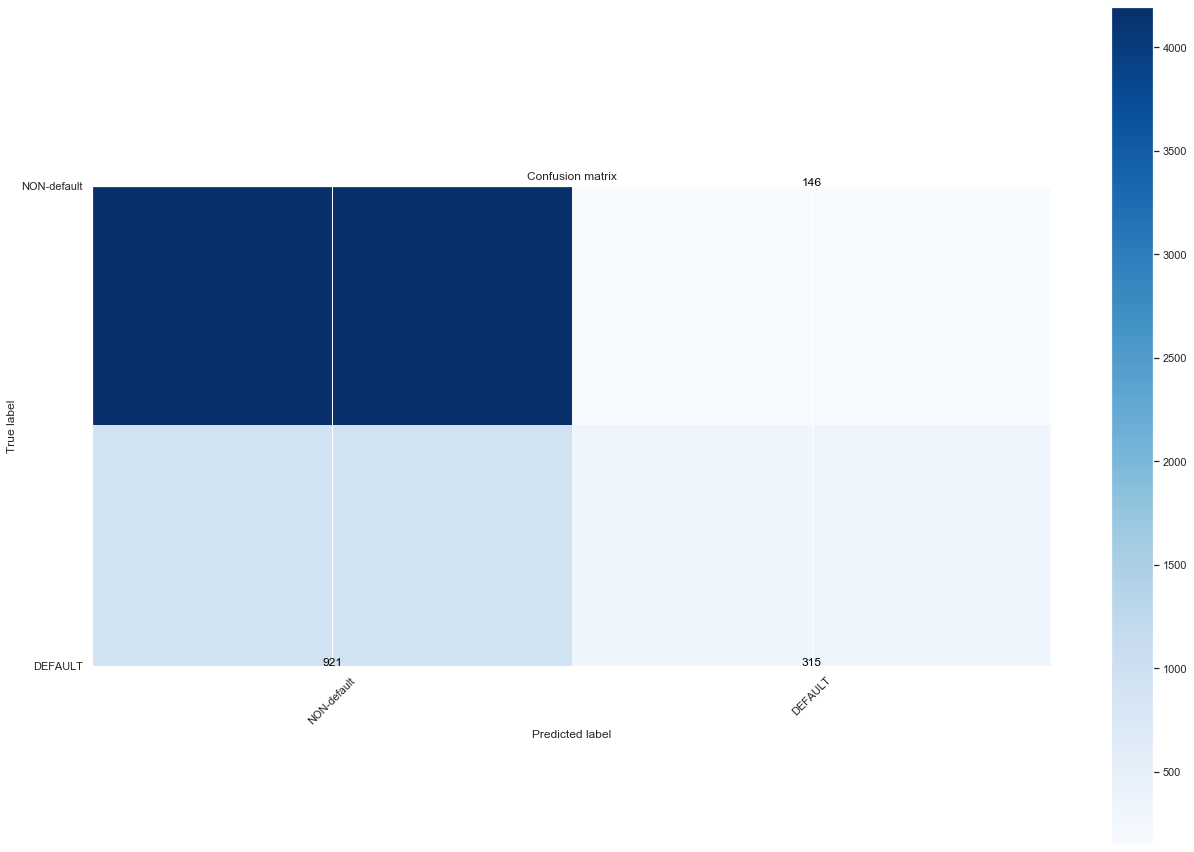

In [60]:
logiRegr(X_trim_train_scaled,y_trim_train,X_trim_test_scaled,y_trim_test)

## 3. Feature Engineering

In [61]:
# Creates the median_inc_edu column
df['median_inc_edu'] = 0

# Populates values
df.loc[df['EDUCATION'] == 1, 'median_inc_edu'] = 831496
df.loc[df['EDUCATION'] == 2, 'median_inc_edu'] = 575575
df.loc[df['EDUCATION'] == 3, 'median_inc_edu'] = 526270
df.loc[df['EDUCATION'] == 4, 'median_inc_edu'] = 417073
df.loc[df['EDUCATION'] == 5, 'median_inc_edu'] = 394230
df.loc[df['EDUCATION'] == 6, 'median_inc_edu'] = 292370

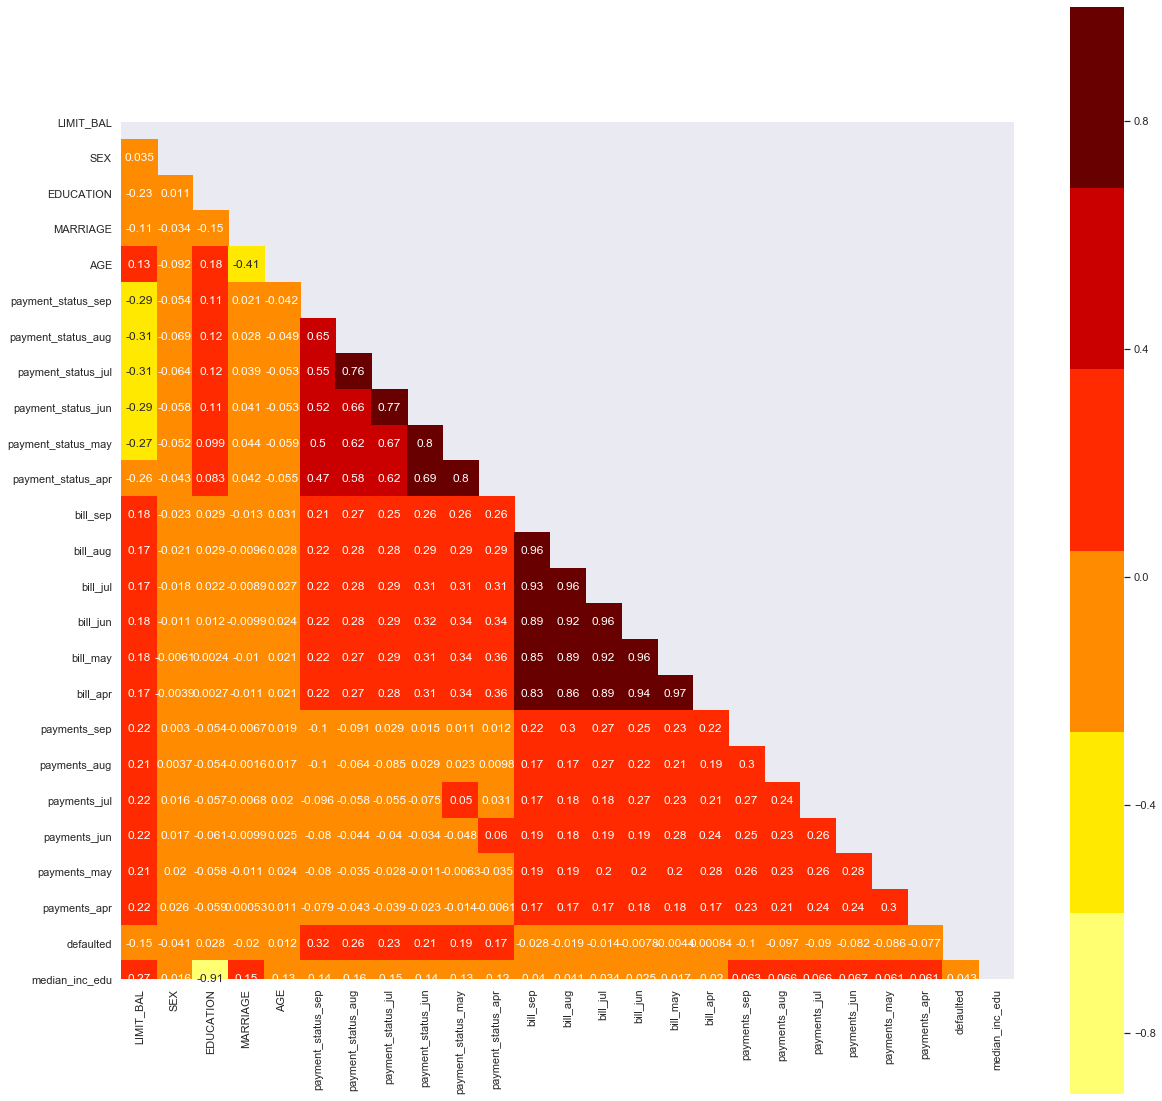

In [62]:
heatmap_corr(df)

In [63]:
# Create temporary df of only those columns we want to check.
df_np = df[['bill_sep','bill_aug','bill_jul','bill_jun','bill_may']]

# Check to see if all values in other "Bill" columns match what is in "Bill_Apr". Returns a boolean. 
df['non_payer'] = df_np.isin(df['bill_apr']).all(1)

# Update to change to numeric and remove those who have not had a balance. 
df['non_payer'] = df.apply(lambda x: 1 if (x.bill_apr > 0) and (x.non_payer == 1) else 0, axis = 1)

In [64]:
df['debt_change'] = df['bill_sep']-df['bill_apr']

In [66]:
df.corr()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_sep,bill_aug,bill_jul,bill_jun,bill_may,bill_apr,payments_sep,payments_aug,payments_jul,payments_jun,payments_may,payments_apr,defaulted,median_inc_edu,non_payer,debt_change
LIMIT_BAL,1.000000,0.035374,-0.232611,-0.110502,0.129283,-0.285626,-0.313337,-0.307433,-0.291037,-0.274833,-0.260068,0.180446,0.167532,0.170444,0.175362,0.175479,0.165700,0.215828,0.212742,0.224378,0.218519,0.214600,0.220331,-0.152731,0.265986,0.013522,0.087309
SEX,0.035374,1.000000,0.011408,-0.033689,-0.092083,-0.053878,-0.069139,-0.064433,-0.057862,-0.051764,-0.043056,-0.022761,-0.021343,-0.017785,-0.011054,-0.006097,-0.003911,0.002998,0.003744,0.016377,0.016648,0.019998,0.025983,-0.041052,-0.016240,-0.031598,-0.035107
EDUCATION,-0.232611,0.011408,1.000000,-0.145981,0.183089,0.106258,0.124171,0.115755,0.109004,0.098724,0.082575,0.029435,0.028797,0.022140,0.011587,0.002430,0.002685,-0.053994,-0.054200,-0.056957,-0.060914,-0.057771,-0.058723,0.027724,-0.907489,-0.004218,0.048767
MARRIAGE,-0.110502,-0.033689,-0.145981,1.000000,-0.409418,0.021149,0.027741,0.038854,0.041405,0.044296,0.041912,-0.012825,-0.009608,-0.008933,-0.009939,-0.010431,-0.010943,-0.006717,-0.001587,-0.006797,-0.009870,-0.011141,0.000527,-0.019965,0.148644,-0.018798,-0.007389
AGE,0.129283,-0.092083,0.183089,-0.409418,1.000000,-0.041652,-0.049015,-0.052548,-0.053129,-0.058900,-0.054506,0.030649,0.027920,0.026787,0.023652,0.021452,0.020644,0.019115,0.016843,0.020066,0.024530,0.023865,0.011446,0.012398,-0.134344,0.024937,0.025466
payment_status_sep,-0.285626,-0.053878,0.106258,0.021149,-0.041652,1.000000,0.646881,0.551965,0.522071,0.497766,0.469328,0.208830,0.218961,0.217767,0.220496,0.221330,0.220818,-0.103099,-0.102324,-0.095615,-0.079960,-0.079995,-0.079145,0.322279,-0.135213,-0.005926,0.059840
payment_status_aug,-0.313337,-0.069139,0.124171,0.027741,-0.049015,0.646881,1.000000,0.760853,0.656339,0.621653,0.581620,0.270716,0.277153,0.275774,0.276359,0.274853,0.273250,-0.090915,-0.063563,-0.057705,-0.044436,-0.034560,-0.043129,0.255947,-0.161925,-0.010724,0.096019
payment_status_jul,-0.307433,-0.064433,0.115755,0.038854,-0.052548,0.551965,0.760853,1.000000,0.765381,0.672454,0.620153,0.251181,0.284957,0.285043,0.287772,0.286602,0.284621,0.028697,-0.085238,-0.054718,-0.040377,-0.027527,-0.039112,0.228341,-0.153441,0.004709,0.045001
payment_status_jun,-0.291037,-0.057862,0.109004,0.041405,-0.053129,0.522071,0.656339,0.765381,1.000000,0.801409,0.692974,0.256006,0.285058,0.311887,0.315599,0.313841,0.313391,0.014769,0.029491,-0.075257,-0.033534,-0.010533,-0.022938,0.207913,-0.144666,0.017771,0.012819
payment_status_may,-0.274833,-0.051764,0.098724,0.044296,-0.058900,0.497766,0.621653,0.672454,0.801409,1.000000,0.799401,0.259488,0.285904,0.311208,0.341321,0.342162,0.338921,0.010739,0.022556,0.049703,-0.048276,-0.006336,-0.013501,0.190216,-0.133310,0.022124,-0.017168


In [67]:
# Calculates rough estimate of the percent of their monthly income dedicated to debt service.
df['percent_of_inc_apr'] = df['bill_apr']/(df['median_inc_edu']/12)
df['percent_of_inc_may'] = df['bill_may']/(df['median_inc_edu']/12)
df['percent_of_inc_jun'] = df['bill_jun']/(df['median_inc_edu']/12)
df['percent_of_inc_jul'] = df['bill_jul']/(df['median_inc_edu']/12)
df['percent_of_inc_aug'] = df['bill_aug']/(df['median_inc_edu']/12)
df['percent_of_inc_sep'] = df['bill_sep']/(df['median_inc_edu']/12)

In [68]:
df.loc[df['defaulted']==1].head(200)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_sep,bill_aug,bill_jul,bill_jun,bill_may,bill_apr,payments_sep,payments_aug,payments_jul,payments_jun,payments_may,payments_apr,defaulted,median_inc_edu,non_payer,debt_change,percent_of_inc_apr,percent_of_inc_may,percent_of_inc_jun,percent_of_inc_jul,percent_of_inc_aug,percent_of_inc_sep
0,50000,1,2,2,49,0,0,0,0,0,0,90231,90647,92309,93880,99418,101392,2852,2784,2603,10000,3164,2868,1,575575,0,-11161,2.113893,2.072738,1.957278,1.924524,1.889874,1.881201
6,400000,2,2,2,41,-2,-2,-2,-2,-2,-2,43672,678,330,330,330,330,678,330,330,330,330,330,1,575575,0,43342,0.006880,0.006880,0.006880,0.006880,0.014135,0.910505
13,200000,1,1,1,37,-1,-1,0,0,0,0,2896,10706,10323,8440,4963,10222,10720,3014,1027,2022,10017,2030,1,831496,0,-7326,0.147522,0.071625,0.121805,0.148980,0.154507,0.041795
17,200000,1,1,2,32,-1,-1,-1,-2,-2,-2,1125,2182,0,0,0,0,2182,0,0,0,0,0,1,831496,0,1125,0.000000,0.000000,0.000000,0.000000,0.031490,0.016236
20,120000,2,2,3,37,2,2,2,2,2,2,26446,27719,27570,28318,29217,28598,2000,600,1500,1500,0,1056,1,575575,0,-2152,0.596232,0.609137,0.590394,0.574799,0.577906,0.551365
23,10000,2,2,2,36,1,2,0,0,0,0,7081,6819,7996,9004,9180,9371,0,1290,1298,474,487,500,1,575575,0,-2290,0.195373,0.191391,0.187722,0.166706,0.142167,0.147630
34,200000,1,1,2,29,-1,-1,-1,0,-1,-1,4810,0,726,726,495,1402,0,726,0,495,1562,1420,1,831496,0,3408,0.020233,0.007144,0.010478,0.010478,0.000000,0.069417
40,10000,2,2,1,24,0,0,0,0,0,0,6902,7922,8939,9533,9692,9829,1142,1159,1140,692,829,1000,1,575575,0,-2927,0.204922,0.202066,0.198751,0.186367,0.165164,0.143898
46,220000,2,2,1,41,-1,2,2,-1,2,-1,650,650,325,950,475,325,325,0,950,0,325,325,1,575575,0,325,0.006776,0.009903,0.019806,0.006776,0.013552,0.013552
47,90000,2,2,1,28,-1,0,0,0,0,0,10962,13244,7097,6624,6806,6266,4512,2500,2397,2150,709,22000,1,575575,0,4696,0.130638,0.141896,0.138102,0.147963,0.276120,0.228544


In [69]:
marriage_dummies = pd.get_dummies(df['MARRIAGE'], prefix="marriage", drop_first=True)
df2 = df.drop('MARRIAGE', axis=1)
df2 = pd.concat([df2, marriage_dummies], axis=1)
df2.head()

,LIMIT_BAL,SEX,EDUCATION,AGE,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_sep,bill_aug,bill_jul,bill_jun,bill_may,bill_apr,payments_sep,payments_aug,payments_jul,payments_jun,payments_may,payments_apr,defaulted,median_inc_edu,non_payer,debt_change,percent_of_inc_apr,percent_of_inc_may,percent_of_inc_jun,percent_of_inc_jul,percent_of_inc_aug,percent_of_inc_sep,marriage_1,marriage_2,marriage_3
0,50000,1,2,49,0,0,0,0,0,0,90231,90647,92309,93880,99418,101392,2852,2784,2603,10000,3164,2868,1,575575,0,-11161,2.113893,2.072738,1.957278,1.924524,1.889874,1.881201,0,1,0
1,30000,1,2,39,0,0,0,0,0,0,20893,22206,19273,16469,14670,11214,2007,2000,2000,417,1500,1500,0,575575,0,9679,0.233798,0.305851,0.343358,0.401817,0.462967,0.435592,1,0,0
2,260000,1,1,27,0,0,0,0,0,0,158711,129796,101721,76699,56738,39134,30000,4132,3410,2600,1800,1200,0,831496,0,119577,0.564775,0.818833,1.106906,1.468019,1.873192,2.290488,0,1,0
3,200000,2,2,33,0,0,0,0,0,0,23762,25944,26988,25237,22131,13774,4000,2000,600,3000,4000,100,0,575575,0,9988,0.287170,0.461403,0.526159,0.562665,0.540899,0.495407,1,0,0
4,50000,1,1,27,0,0,0,0,0,0,14614,15622,16342,17653,17697,18068,1558,1278,1589,633,656,783,0,831496,0,-3454,0.260754,0.255400,0.254765,0.235845,0.225454,0.210907,0,1,0


In [70]:
sex_dummies = pd.get_dummies(df['SEX'], prefix="sex", drop_first=True)
df2 = df2.drop('SEX', axis=1)
df2 = pd.concat([df2, sex_dummies], axis=1)
df2.head()

,LIMIT_BAL,EDUCATION,AGE,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_sep,bill_aug,bill_jul,bill_jun,bill_may,bill_apr,payments_sep,payments_aug,payments_jul,payments_jun,payments_may,payments_apr,defaulted,median_inc_edu,non_payer,debt_change,percent_of_inc_apr,percent_of_inc_may,percent_of_inc_jun,percent_of_inc_jul,percent_of_inc_aug,percent_of_inc_sep,marriage_1,marriage_2,marriage_3,sex_2
0,50000,2,49,0,0,0,0,0,0,90231,90647,92309,93880,99418,101392,2852,2784,2603,10000,3164,2868,1,575575,0,-11161,2.113893,2.072738,1.957278,1.924524,1.889874,1.881201,0,1,0,0
1,30000,2,39,0,0,0,0,0,0,20893,22206,19273,16469,14670,11214,2007,2000,2000,417,1500,1500,0,575575,0,9679,0.233798,0.305851,0.343358,0.401817,0.462967,0.435592,1,0,0,0
2,260000,1,27,0,0,0,0,0,0,158711,129796,101721,76699,56738,39134,30000,4132,3410,2600,1800,1200,0,831496,0,119577,0.564775,0.818833,1.106906,1.468019,1.873192,2.290488,0,1,0,0
3,200000,2,33,0,0,0,0,0,0,23762,25944,26988,25237,22131,13774,4000,2000,600,3000,4000,100,0,575575,0,9988,0.287170,0.461403,0.526159,0.562665,0.540899,0.495407,1,0,0,1
4,50000,1,27,0,0,0,0,0,0,14614,15622,16342,17653,17697,18068,1558,1278,1589,633,656,783,0,831496,0,-3454,0.260754,0.255400,0.254765,0.235845,0.225454,0.210907,0,1,0,0


In [71]:
df2.to_csv('master_df.csv',index=False)

### 3b. Engineered Model

In [72]:
X_dummy = df2.drop('defaulted', axis=1)
y_dummy = df2['defaulted']
X_dummy_train, X_dummy_test, y_dummy_train, y_dummy_test = train_test_split(X_dummy, y_dummy, random_state=1)

In [73]:
scaler = StandardScaler()  
scaler.fit(X_dummy_train)

X_dummy_train_scaled = pd.DataFrame(scaler.transform(X_dummy_train), columns=X_dummy_train.columns) 
X_dummy_test_scaled = pd.DataFrame(scaler.transform(X_dummy_test), columns=X_dummy_test.columns)

/Users/jmcneilkeller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[('LIMIT_BAL', -0.061084272092714574),
 ('EDUCATION', -0.08177600935782332),
 ('AGE', 0.03998186939260752),
 ('payment_status_sep', 0.6217604903566077),
 ('payment_status_aug', 0.11927194522204707),
 ('payment_status_jul', 0.08781731617924078),
 ('payment_status_jun', 0.05509554342436796),
 ('payment_status_may', 0.01410853796064428),
 ('payment_status_apr', 0.0151855624791286),
 ('bill_sep', -0.2876885386034571),
 ('bill_aug', 0.2547416154689434),
 ('bill_jul', 0.4604741088279283),
 ('bill_jun', -0.336406624918617),
 ('bill_may', -0.00047340045255334084),
 ('bill_apr', -0.1405908900009434),
 ('payments_sep', -0.10873643501265046),
 ('payments_aug', -0.16030749995399635),
 ('payments_jul', -0.08704331930185409),
 ('payments_jun', -0.07128833876487946),
 ('payments_may', -0.1404740209088281),
 ('payments_apr', -0.06931403733901693),
 ('median_inc_edu', 0.01674067724327759),
 ('non_payer', 0.11659860921734244),
 ('debt_change', -0.31532843037252023),
 ('percent_of_inc_apr', -0.0545148030

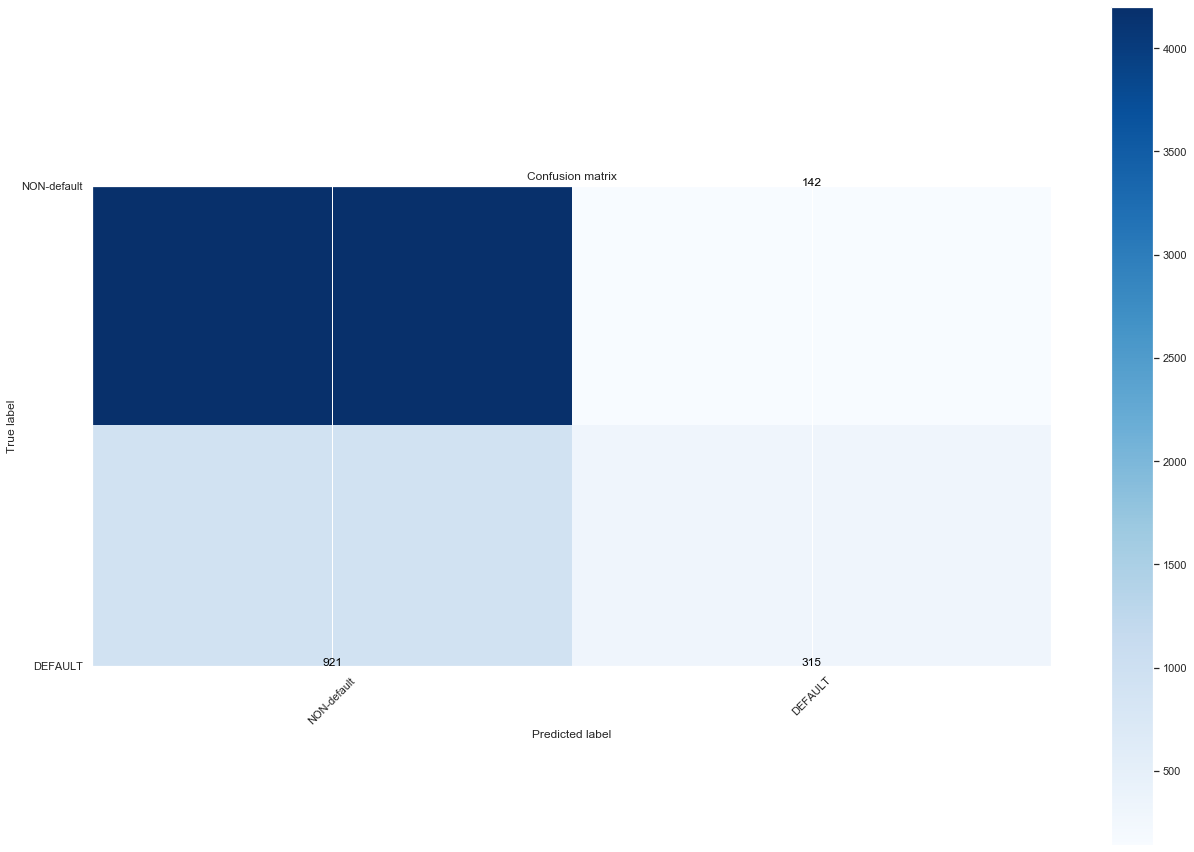

In [74]:
logiRegr(X_dummy_train_scaled,y_dummy_train,X_dummy_test_scaled,y_dummy_test)

### 3b(1): Decision Tree

In [88]:
deciTree(X_dummy_train_scaled,y_dummy_train,X_dummy_test_scaled,y_dummy_test, max_depth=4)

Classification Accuracy:  0.818
Precision score:  0.641
Recall score:  0.408
F1 score:  0.499


In [99]:
knn(X_dummy_train_scaled,y_dummy_train,X_dummy_test_scaled,y_dummy_test,n_neighbors=10)

Classification Accuracy:  0.801
Precision score:  0.623
Recall score:  0.255
F1 score:  0.362


In [113]:
randomForest(X_dummy_train_scaled,y_dummy_train,X_dummy_test_scaled,y_dummy_test, max_depth=15)

/Users/jmcneilkeller/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classification Accuracy:  0.814
Precision score:  0.640
Recall score:  0.364
F1 score:  0.464
